In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/DATA QUALITY MANAGEMENT')

In [4]:
%cd /content/drive/My Drive/Colab Notebooks/DATA QUALITY MANAGEMENT

/content/drive/My Drive/Colab Notebooks/DATA QUALITY MANAGEMENT


In [5]:
import pandas as pd
import numpy as np
import random
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [6]:
def generate_valid_name():
    valid_name = ''

    # Generate first name
    first_name = ''.join(random.choices(string.ascii_uppercase, k=1)) + ''.join(random.choices(string.ascii_lowercase, k=random.randint(2, 7)))
    valid_name += first_name

    # Generate middle name
    if random.random() < 0.5:
        middle_name = ''.join(random.choices(string.ascii_uppercase, k=1)) + ''.join(random.choices(string.ascii_lowercase, k=random.randint(2, 7)))
        valid_name += ' ' + middle_name

    # Generate last name
    last_name = ''.join(random.choices(string.ascii_uppercase, k=1)) + ''.join(random.choices(string.ascii_lowercase, k=random.randint(2, 7)))
    valid_name += ' ' + last_name

    return valid_name

def generate_invalid_name():
    invalid_chars = string.punctuation + string.digits
    invalid_name = ''

    # Generate first name
    first_name = ''.join(random.choices(string.ascii_lowercase, k=random.randint(3, 8)))
    if random.random() < 0.5:
        first_name = ''.join(random.choices(invalid_chars, k=random.randint(1, 3))) + first_name
    invalid_name += first_name

    # Generate middle name
    if random.random() < 0.5:
        middle_name = ''.join(random.choices(string.ascii_lowercase, k=random.randint(3, 8)))
        if random.random() < 0.5:
            middle_name = ''.join(random.choices(invalid_chars, k=random.randint(1, 3))) + middle_name
        invalid_name += ' ' + middle_name

    # Generate last name
    last_name = ''.join(random.choices(string.ascii_lowercase, k=random.randint(3, 8)))
    if random.random() < 0.5:
        last_name = ''.join(random.choices(invalid_chars, k=random.randint(1, 3))) + last_name
    invalid_name += ' ' + last_name

    # Add double space
    if random.random() < 0.3:
        invalid_name = invalid_name.replace(' ', '  ')

    return invalid_name

def validate_name(text):
    pattern = r'^[a-zA-Z]+(?: [a-zA-Z]+)*$'
    if re.match(pattern, text):
        return 1
    else:
        return 0

def make_teks_proper(text):
    # Replace special character and numbers in the middle of string with space
    cleaned_string = re.sub(r'[^A-Za-z\s]+', ' ', text)
    # Remove non alphabetic character except space
    cleaned_string = re.sub(r'\s{2,}', r' ', cleaned_string)
    return cleaned_string.strip()  # Remove space in the first and last string

def upperCaseCheck(name):
    pattern = r'^[A-Z][a-z\s]*$'
    return re.match(pattern, name) is not None


In [7]:
data  = []
initial_label = []
check_type = []

for _ in range(1000):
  data.append(generate_valid_name())
  initial_label.append(1)
  check_type.append('name')

for _ in range(1000):
  data.append(generate_invalid_name())
  initial_label.append(1)
  check_type.append('name')

In [8]:
dataset = pd.DataFrame({"text" : data, 'initial_label' : initial_label, 'data_type': check_type})
dataset.to_csv('dataset/name_dataset.csv')
dataset

,text,initial_label,data_type
0,Cdzjcamc Ofrfn Xfq,1,name
1,Ihj Txtmivh,1,name
2,Fcvns Hmfgkxv,1,name
3,Aor Jip Qjiooe,1,name
4,Utpbf Njoarvs,1,name
...,...,...,...
1995,9~smqcjzhu veowsdi 1/nhgnsxqe,1,name
1996,ehyevz ghxfez kzaz,1,name
1997,6[?nsteuqy rucbt,1,name
1998,7ustlrl fvlw,1,name


In [9]:
dataset['label'] = dataset['text'].apply(lambda x: validate_name(x))
dataset['clean'] = dataset.apply(lambda x: make_teks_proper(str(x['text'])) if x['label'] == False else x['text'], axis=1)
dataset['check'] = dataset['clean'].apply(lambda x: validate_name(x))

dataset[['text','label','clean','check']]

,text,label,clean,check
0,Cdzjcamc Ofrfn Xfq,1,Cdzjcamc Ofrfn Xfq,1
1,Ihj Txtmivh,1,Ihj Txtmivh,1
2,Fcvns Hmfgkxv,1,Fcvns Hmfgkxv,1
3,Aor Jip Qjiooe,1,Aor Jip Qjiooe,1
4,Utpbf Njoarvs,1,Utpbf Njoarvs,1
...,...,...,...,...
1995,9~smqcjzhu veowsdi 1/nhgnsxqe,0,smqcjzhu veowsdi nhgnsxqe,1
1996,ehyevz ghxfez kzaz,0,ehyevz ghxfez kzaz,1
1997,6[?nsteuqy rucbt,0,nsteuqy rucbt,1
1998,7ustlrl fvlw,0,ustlrl fvlw,1


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, SpatialDropout1D, Embedding, Dropout
import numpy as np

data = dataset
max_words = 1000

# Preprocessing data
vectorizer = CountVectorizer(max_features=max_words, analyzer='char')
X = vectorizer.fit_transform(data['text'].values).toarray()

# Definisikan model
model = Sequential()
model.add(Dense(128, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train-test split
Y = data['label'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
# Training model
history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_test, Y_test))

# Evaluasi model
score, acc = model.evaluate(X_test, Y_test, batch_size=32)
print("Accuracy: %.2f%%" % (acc*100))

Epoch 1/15
50/50 [==============================] - 1s 7ms/step - loss: 0.7132 - accuracy: 0.5231 - val_loss: 0.6623 - val_accuracy: 0.6225
Epoch 2/15
50/50 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.6106 - val_loss: 0.6232 - val_accuracy: 0.7450
Epoch 3/15
50/50 [==============================] - 0s 4ms/step - loss: 0.6161 - accuracy: 0.6769 - val_loss: 0.5325 - val_accuracy: 0.8100
Epoch 4/15
50/50 [==============================] - 0s 4ms/step - loss: 0.4989 - accuracy: 0.7763 - val_loss: 0.3899 - val_accuracy: 0.8850
Epoch 5/15
50/50 [==============================] - 0s 4ms/step - loss: 0.4232 - accuracy: 0.8206 - val_loss: 0.3032 - val_accuracy: 0.9050
Epoch 6/15
50/50 [==============================] - 0s 3ms/step - loss: 0.3462 - accuracy: 0.8625 - val_loss: 0.2350 - val_accuracy: 0.9250
Epoch 7/15
50/50 [==============================] - 0s 3ms/step - loss: 0.2952 - accuracy: 0.8913 - val_loss: 0.1841 - val_accuracy: 0.9450
Epoch 8/15
50/50 [==

In [13]:
#Save models dan feature vector to directory

import pickle

model.save("model/name_validation_single_lstm_model.keras")

with open('model/name_validation_single_lstm_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

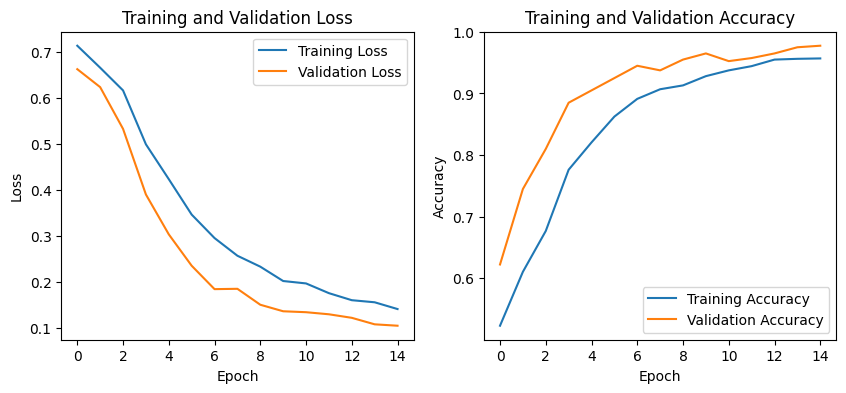

In [14]:
# Visualisasi loss dan akurasi
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [15]:
# Predictions
Y_pred_prob = model.predict(X_test)
Y_pred = (Y_pred_prob > 0.5).astype(int)

# Classification report
print(classification_report(Y_test, Y_pred))

13/13 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       171
           1       0.96      1.00      0.98       229

    accuracy                           0.98       400
   macro avg       0.98      0.97      0.98       400
weighted avg       0.98      0.98      0.98       400



In [16]:
#Using Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

# Predictions on training and validation set
Y_train_pred = logreg.predict(X_train)
Y_test_pred = logreg.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", test_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(Y_test, Y_test_pred))

Training Accuracy: 0.958125
Validation Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94       171
           1       0.92      1.00      0.96       229

    accuracy                           0.95       400
   macro avg       0.96      0.94      0.95       400
weighted avg       0.95      0.95      0.95       400



In [17]:
#Save Logistic Regression Models
from joblib import dump
dump(logreg, 'model/name_validation_single_logistic_regression_model.joblib')

['model/name_validation_single_logistic_regression_model.joblib']

In [18]:
#Prediction Using LSTM
from keras.models import load_model
import pickle

# Load Trained Model
model = load_model("model/name_validation_single_lstm_model.keras")

# Load Tokenizer from directory
with open('model/name_validation_single_lstm_vectorizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# To be Predicted
new_data = ["John Doe", "Jane &Smith"]

# Feature Extraction
new_data_extract = tokenizer.transform(new_data).toarray()

# Perform prediction using LSTM Models
predictions = model.predict(new_data_extract)

# Show prediction result
for name, prediction in zip(new_data, predictions):
    label = "Valid" if prediction > 0.5 else "Invalid"
    confidence = prediction[0] if prediction > 0.5 else 1 - prediction[0]
    print(f"Nama: {name}, Prediksi: {label}, Accuracy: {confidence:.2f}")


1/1 [==============================] - 0s 257ms/step
Nama: John Doe, Prediksi: Valid, Accuracy: 0.93
Nama: Jane &Smith, Prediksi: Invalid, Accuracy: 0.95


In [19]:
#Prediction using Logistic Regression Model
from joblib import load

# Memuat model logistic regression dari file
logreg = load('model/name_validation_single_logistic_regression_model.joblib')

# Data baru untuk diprediksi
new_data = ["John Doe", "Jane?Smith", "Jane&samantha", "Lynda*kork"]

# Load Tokenizer from directory
with open('model/name_validation_single_lstm_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

# Transformasi data baru menggunakan vectorizer yang telah diproses sebelumnya
new_data_transformed = vectorizer.transform(new_data)

# Melakukan prediksi
predictions = logreg.predict(new_data_transformed)

# Menampilkan hasil prediksi
for name, prediction in zip(new_data, predictions):
    label = "Valid" if prediction == 1 else "Invalid"
    print(f"Nama: {name}, Prediksi: {label}")

Nama: John Doe, Prediksi: Valid
Nama: Jane?Smith, Prediksi: Invalid
Nama: Jane&samantha, Prediksi: Valid
Nama: Lynda*kork, Prediksi: Valid
